GitHub Copilot

## CLIP 模型与 Jina CLIP 和 OpenVINO

[jina-clip-v1](https://huggingface.co/jinaai/jina-clip-v1) 是一个由 [Jina AI](https://aimodels.fyi/creators/huggingFace/jinaai) 训练的最先进的英语多模态（文本-图像）嵌入模型。它弥合了传统文本嵌入模型（在文本到文本检索方面表现出色但无法执行跨模态任务）与能够有效对齐图像和文本嵌入但未针对文本到文本检索优化的模型之间的差距。jina-clip-v1 在这两个领域都提供了强大的性能。其双重能力使其成为多模态检索增强生成 (MuRAG) 应用程序的绝佳工具，允许在单个模型内无缝进行文本到文本和文本到图像搜索。jina-clip-v1 可用于各种多模态应用，例如：通过文本描述搜索图像、多模态问答、多模态内容生成。Jina AI 还提供了 Embeddings API，作为使用 jina-clip-v1 及其他嵌入模型的易用接口。

在本笔记本中，我们将使用 Hugging Face Transformers 加载模型，将其转换为 OpenVINO IR 格式，使用 NNCF 优化它，并展示实时演示。

#### 目录：

- [前提条件](#Prerequisites)
- [实例化模型](#Instantiate-model)
    - [准备输入数据](#Prepare-input-data)
    - [运行 PyTorch 模型推理](#Run-PyTorch-model-inference)
- [运行 OpenVINO 模型推理](#Run-OpenVINO-model-inference)
    - [准备输入数据](#Prepare-input-data)
    - [将模型转换为 OpenVINO IR 格式](#Convert-Model-to-OpenVINO-IR-format)
    - [选择推理设备](#Select-inference-device)
    - [编译模型并运行推理](#Compile-model-and-run-inference)
- [使用 NNCF 将模型量化为 INT8](#Quantize-model-to-INT8-using-NNCF)
    - [准备数据集](#Prepare-datasets)
        - [文本数据集](#Dataset-with-text-data)
        - [图像数据集](#Dataset-with-image-data)
    - [执行量化](#Perform-quantization)
        - [文本模型的量化](#Quantization-of-text-model)
        - [图像模型的量化](#Quantization-of-image-model)
    - [比较文件大小](#Compare-File-Size)
    - [比较 FP16 IR 和量化模型的推理时间](#Compare-inference-time-of-the-FP16-IR-and-quantized-models)
- [Gradio 演示](#Gradio-demo)


### 安装说明

这是一个仅依赖于自身代码的自包含示例。

我们建议在虚拟环境中运行笔记本。您只需要一个 Jupyter 服务器即可开始。
有关详细信息，请参阅[安装指南](https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/README.md#-installation-guide)。

<img referrerpolicy="no-referrer-when-downgrade" src="https://static.scarf.sh/a.png?x-pxid=5b5a4db0-7875-4bfb-bdbd-01698b5b1a77&file=notebooks/jina-clip/jina-clip.ipynb" />


## Prerequisites
[back to top ⬆️](#Table-of-contents:)

In [12]:
import platform

%pip install -q "openvino>=2024.6.0" "datasets>=2.20" "nncf>=2.14.0"
%pip install -q --extra-index-url https://download.pytorch.org/whl/cpu "gradio>=4.19" "pillow" "einops" "timm" "transformers[torch]>=4.39" "torch>=2.1" "matplotlib>=3.4" "typing_extensions>=4.9"

if platform.system() == "Darwin":
    %pip install -q "numpy<2.0.0"

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## 实例化模型
[back to top ⬆️](#Table-of-contents:)

让我们使用 Hugging Face Transformers 加载 [jinaai/jina-clip-v1](https://huggingface.co/jinaai/jina-clip-v1)。我们使用 `AutoModel` 创建 PyTorch 模型类实例，并通过 `from_pretrained` 方法加载并初始化模型配置和权重。


In [13]:
from transformers import AutoModel
model_path = r"C:\Users\k\Desktop\BaiduSyncdisk\baidu_sync_documents\hf_models\jina-clip-v2"
model = AutoModel.from_pretrained(model_path, trust_remote_code=True)

### 准备输入数据
[back to top ⬆️](#Table-of-contents:)

该模型可以对有意义的英文句子进行编码作为文本输入。图像可以通过本地文件路径、URL 或直接传入 PIL.Image 对象的方式提供给模型。

In [7]:
from PIL import Image
import requests
from pathlib import Path

In [14]:


# 确保 notebook_utils.py 可用，如果本地不存在则下载
utils_path = Path("notebook_utils.py")
if not utils_path.exists():
    resp = requests.get(
        "https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py"
    )
    utils_path.write_text(resp.text)

# 创建 data 目录用于存放下载的图片
data_dir = Path("data")
data_dir.mkdir(exist_ok=True)

# 下载 furseal 图像到本地
furseal_path = data_dir / "furseal.png"
if not furseal_path.exists():
    resp = requests.get(
        "https://github.com/openvinotoolkit/openvino_notebooks/assets/29454499/3f779fc1-c1b2-4dec-915a-64dae510a2bb",
        stream=True,
    )
    furseal_path.write_bytes(resp.content)

# 下载 coco 图像到本地
coco_path = data_dir / "coco.jpg"
if not coco_path.exists():
    resp = requests.get(
        "https://github.com/user-attachments/assets/1c66a05d-7442-45c2-a34c-bb08b95af7a6",
        stream=True,
    )
    coco_path.write_bytes(resp.content)


In [15]:

# 加载并打开图片
img_furseal = Image.open(furseal_path)
img_coco   = Image.open(coco_path)

# 准备模型输入：图像列表和文本标签列表
IMAGE_INPUTS = [img_furseal, img_coco]
TEXT_INPUTS  = ["Seal", "Cobra", "Rat", "Penguin", "Dog"]

# 收集使用情况遥测
from notebook_utils import collect_telemetry
collect_telemetry("jina-clip.ipynb")

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import softmax

def calc_simularity_softmax(embeddings1, embeddings2, apply_softmax=True):
  """
  计算两个嵌入向量列表之间的相似度并可选地应用 softmax。
  参数:
    embeddings1: Iterable，第一个嵌入向量列表。
    embeddings2: Iterable，第二个嵌入向量列表。
    apply_softmax: bool，是否对相似度分数应用 softmax，默认 True。
  返回:
    List[List[float]]，每个 embeddings1 中向量与 embeddings2 中所有向量的相似度分数列表。
  """
  simularity = []
  for emb1 in embeddings1:
    scores = [emb1 @ emb2 for emb2 in embeddings2]
    if apply_softmax:
      scores = softmax(scores)
    simularity.append(scores)
  return simularity

def visionize_result(image: Image.Image, labels: list[str], probs: np.ndarray, top: int = 5):
  """
  可视化零样本分类结果。
  参数:
    image: PIL.Image.Image，输入图像。
    labels: list[str]，分类标签列表。
    probs: np.ndarray，模型输出的 softmax 概率。
    top: int，要展示的最高概率标签数量，默认 5。
  """
  plt.figure(figsize=(8, 8))
  # 取 top 个概率最大的标签
  top_idxs = np.argsort(-probs)[:min(top, probs.shape[0])]
  top_probs = probs[top_idxs]
  # 显示原图
  plt.subplot(2, 1, 1)
  plt.imshow(image)
  plt.axis("off")
  # 显示水平柱状图
  plt.subplot(2, 1, 2)
  y = np.arange(len(top_probs))
  plt.barh(y, top_probs)
  plt.gca().invert_yaxis()
  plt.yticks(y, [labels[i] for i in top_idxs])
  plt.xlabel("相似度")
  plt.grid(True)
  plt.tight_layout()

我们将使用来自 jina-clip 模型的 `tokenizer` 和 `preprocess`。我们将使用 `model.get_tokenizer()` 获取的 `tokenizer` 对文本输入数据进行编码，并使用 `model.get_preprocess()` 获取的 `preprocess` 对图像数据进行预处理。

In [17]:
tokenizer = model.get_tokenizer()

tokenizer_kwargs = dict()
tokenizer_kwargs["padding"] = "max_length"
tokenizer_kwargs["max_length"] = 512
tokenizer_kwargs["truncation"] = True

text_inputs = tokenizer(
    TEXT_INPUTS,
    return_tensors="pt",
    **tokenizer_kwargs,
).to("cpu")


processor = model.get_preprocess()
vision_inputs = processor(images=IMAGE_INPUTS, return_tensors="pt")

### 运行 PyTorch 模型推理
[返回顶部 ⬆️](#Table-of-contents:)

C:\Users\k\AppData\Local\Temp\ipykernel_89020\1505217980.py:48: UserWarning: Glyph 30456 (\N{CJK UNIFIED IDEOGRAPH-76F8}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\k\AppData\Local\Temp\ipykernel_89020\1505217980.py:48: UserWarning: Glyph 20284 (\N{CJK UNIFIED IDEOGRAPH-4F3C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\k\AppData\Local\Temp\ipykernel_89020\1505217980.py:48: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\k\.conda\envs\openvino\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 30456 (\N{CJK UNIFIED IDEOGRAPH-76F8}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
c:\Users\k\.conda\envs\openvino\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 20284 (\N{CJK UNIFIED IDEOGRAPH-4F3C}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
c:\Users\k\.conda\envs\openvino\lib\site-packages\IPython\core\events.py:82: UserWa

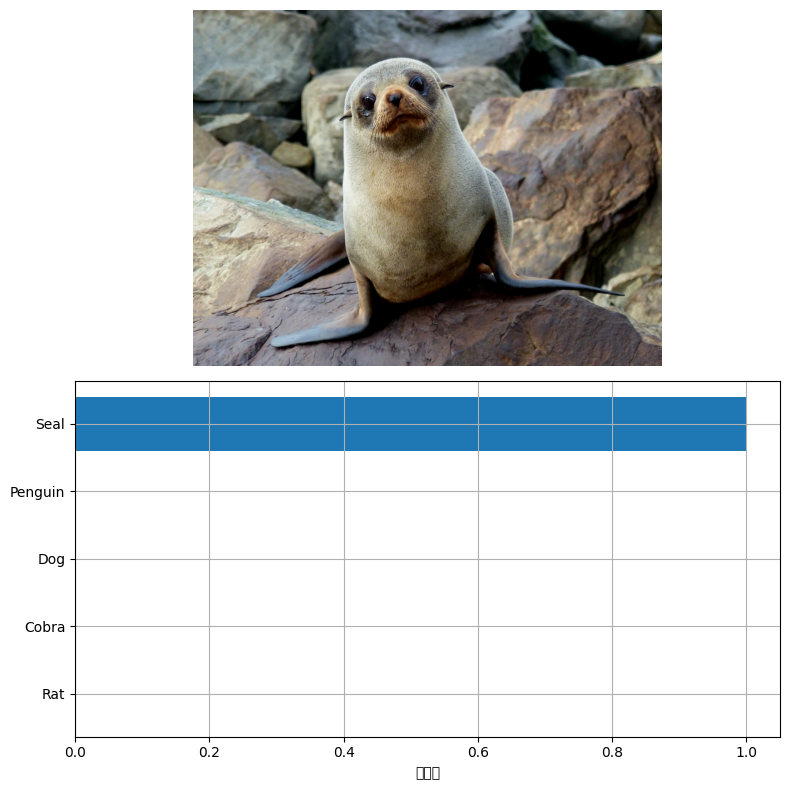

In [18]:
# 对文本输入计算文本嵌入
text_embeddings = model.text_model(text_inputs["input_ids"])
# 对图像输入计算图像嵌入
image_embeddings = model.vision_model(vision_inputs["pixel_values"])

# 将张量转换为 numpy 并计算相似度（带 softmax）
res = calc_simularity_softmax(
    image_embeddings.detach().numpy(),  # 图像嵌入 numpy 数组
    text_embeddings.detach().numpy(),   # 文本嵌入 numpy 数组
)

# 可视化第一张图像与所有文本标签的相似度结果
visionize_result(img_furseal, TEXT_INPUTS, np.array(res[0]))

## 运行 OpenVINO 模型推理
[返回顶部 ⬆️](#Table-of-contents:)

### 将模型转换为 OpenVINO IR 格式
[返回顶部 ⬆️](#Table-of-contents:)

OpenVINO 支持通过将 PyTorch 模型转换为 OpenVINO 中间表示（IR）来进行推理。要实现此目的，应使用 OpenVINO 的模型转换 API。`ov.convert_model` 函数接受原始的 PyTorch 模型实例和用于追踪的示例输入，并返回一个在 OpenVINO 框架中表示该模型的 `ov.Model`。转换后的模型可以使用 `ov.save_model` 函数保存到磁盘，或使用 `core.compile_model` 直接加载到设备上进行推理。

In [2]:
import openvino as ov
from pathlib import Path

core = ov.Core()

In [20]:
fp16_text_model_path = Path("jina-clip-text_v2_fp16.xml")

if not fp16_text_model_path.exists():
    ov_text_model = ov.convert_model(model.text_model, example_input=text_inputs["input_ids"])
    ov.save_model(ov_text_model, fp16_text_model_path)

In [21]:
fp16_vision_model_path = Path("jina-clip-vision_v2_fp16.xml")

if not fp16_vision_model_path.exists():
    ov_vision_model = ov.convert_model(model.vision_model, example_input=vision_inputs["pixel_values"])
    ov.save_model(ov_vision_model, fp16_vision_model_path)

C:\Users\k\.cache\huggingface\modules\transformers_modules\jinaai\jina-clip-implementation\51f02de9f2cf8afcd3bac4ce996859ba96f9f8e9\eva_model.py:471: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert h == self.img_size[0] and w == self.img_size[1], (


### 选择推理设备
[返回顶部 ⬆️](#Table-of-contents:)

开始工作前，请从下拉列表中选择推理设备。

In [28]:
from notebook_utils import device_widget


device = device_widget()
device

Dropdown(description='Device:', index=3, options=('CPU', 'GPU', 'NPU', 'AUTO'), value='AUTO')

### 编译模型并运行推理
[返回顶部 ⬆️](#Table-of-contents:)

In [29]:
print(fp16_text_model_path)

jina-clip-text_v2_fp16.xml


In [30]:
compiled_text_model = core.compile_model(fp16_text_model_path, device.value)
compiled_vision_model = core.compile_model(fp16_vision_model_path, device.value)

RuntimeError: Exception from src\inference\src\cpp\core.cpp:129:
Exception from src\inference\src\dev\plugin.cpp:58:
Exception from src\plugins\intel_npu\src\plugin\src\plugin.cpp:778:
Exception from src\plugins\intel_npu\src\compiler_adapter\src\ze_graph_ext_wrappers.cpp:362:
L0 pfnCreate2 result: ZE_RESULT_ERROR_INVALID_ARGUMENT, code 0x78000004 - generic error code for invalid arguments . [NPU_VCL] Compiler returned msg:
[NOT IMPLEMENTED] Unsupported operation __module.transformer.roberta.embeddings/aten::_unique2/Unique with type Unique and version opset10. Try to update the driver to the latest version. If the error persists, please submit a bug report in https://github.com/openvinotoolkit/openvino/issues





In [31]:
text_ov_res = compiled_text_model(text_inputs["input_ids"])
vis_ov_res = compiled_vision_model(vision_inputs["pixel_values"])



In [ ]:
res = calc_simularity_softmax(vis_ov_res[0], text_ov_res[0])
visionize_result(img_furseal, TEXT_INPUTS, np.array(res[0]))

## 使用 NNCF 将模型量化为 INT8
[返回顶部 ⬆️](#Table-of-contents:)

让我们通过应用来自 [NNCF](https://github.com/openvinotoolkit/nncf/)（神经网络压缩框架）的 8 位后训练量化来加速模型，并使用 OpenVINO™ 工具包推理量化后的模型。NNCF 通过在模型图中添加量化层并使用训练数据集的子集来初始化这些附加量化层的参数，从而实现后训练量化。量化后的操作以 `INT8` 而不是 `FP32`/`FP16` 执行，从而提高模型推理速度。该优化过程包含以下步骤：

1. 准备量化数据集  
2. 使用 `nncf.quantize()` 对转换后的 OpenVINO 模型进行量化  
3. 使用 `openvino.save_model()` 函数保存 `INT8` 模型  
4. 比较转换后模型和量化模型的文件大小  
5. 比较转换后模型和量化模型的性能  

> **注意：** 量化过程可能需要额外的时间和内存。您可以使用下面的控件禁用它：


In [13]:
to_quantize = quantization_widget()

to_quantize

Checkbox(value=True, description='Quantization')

In [14]:
if not Path("skip_kernel_extension.py").exists():
    # Fetch `skip_kernel_extension` module
    r = requests.get(
        url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/skip_kernel_extension.py",
    )
    open("skip_kernel_extension.py", "w").write(r.text)

int8_text_model_path = Path("jina-clip-text_v1_int8.xml")
int8_vision_model_path = Path("jina-clip-vision_v1_int8.xml")

%load_ext skip_kernel_extension

### 准备数据集
[返回顶部 ⬆️](#Table-of-contents:)

使用 [Conceptual Captions](https://ai.google.com/research/ConceptualCaptions/) 数据集（包含约 330 万张带有标题注释的图像）来对模型进行量化。

#### 文本数据集
[返回顶部 ⬆️](#Table-of-contents:)

In [ ]:
%%skip not $to_quantize.value

import torch
from datasets import load_dataset
from tqdm.notebook import tqdm
import requests
from io import BytesIO
import numpy as np
from PIL import Image
from requests.packages.urllib3.exceptions import InsecureRequestWarning
requests.packages.urllib3.disable_warnings(InsecureRequestWarning)


def check_text_data(data):
    """
    检查输入数据是否为文本格式。
    参数:
        data: 待检查的数据，可为字符串或字符串列表。
    返回:
        bool: 如果数据为字符串或字符串列表，返回 True，否则返回 False。
    """
    if isinstance(data, str):
        return True
    if isinstance(data, list):
        return all(isinstance(x, str) for x in data)
    return False


def collate_fn_text(example, text_column="caption"):
    """
    文本数据预处理函数。
    参数:
        example: 列表，每个元素为一个包含文本的字典。
        text_column: 文本字段名称，默认为 "caption"。
    返回:
        dict: tokenizer 编码后的文本输入张量。
    抛出:
        ValueError: 当文本数据无效时触发。
    """
    assert len(example) == 1
    example = example[0]

    if not check_text_data(example[text_column]):
        raise ValueError("文本数据无效")

    # 使用 tokenizer 对文本进行编码
    text_input = tokenizer(
        example[text_column],
        return_tensors='pt',
        **tokenizer_kwargs
    )

    return text_input


def prepare_calibration_data_text(dataloader, init_steps):
    """
    准备文本模型量化校准数据。
    参数:
        dataloader: 文本数据加载器。
        init_steps: 需要采集的样本数量。
    返回:
        list: 包含 input_ids 张量的列表，用于量化校准。
    """
    data = []
    print(f"正在采集 {init_steps} 个样本用于初始化...")
    with tqdm(total=init_steps) as pbar:
        for batch in dataloader:
            if len(data) == init_steps:
                break
            if batch:
                pbar.update(1)
                with torch.no_grad():
                    data.append(batch["input_ids"].to("cpu"))
    return data

In [16]:
%%skip not $to_quantize.value

import logging
import nncf

if not int8_text_model_path.exists():
    dataset = load_dataset("google-research-datasets/conceptual_captions", trust_remote_code=True)
    train_dataset = dataset["train"].shuffle(seed=42)

    dataloader_text = torch.utils.data.DataLoader(train_dataset, collate_fn=collate_fn_text, batch_size=1)
    calibration_data_text = prepare_calibration_data_text(dataloader_text, 50)

INFO:nncf:NNCF initialized successfully. Supported frameworks detected: torch, tensorflow, onnx, openvino
Fetching 50 samples for the initialization...


  0%|          | 0/50 [00:00<?, ?it/s]

#### 图像数据集
[返回顶部 ⬆️](#Table-of-contents:)

In [ ]:
%%skip not $to_quantize.value

def get_pil_from_url(url):
    """
    从 URL 下载并将图像转换为 PIL Image 对象。
    """
    response = requests.get(url, verify=False, timeout=20)
    image = Image.open(BytesIO(response.content))
    return image.convert("RGB")


def collate_fn_vision(example, image_column="image_url"):
    """
    对单个样本进行预处理：根据 image_column 中的 URL 调用 get_pil_from_url 下载图像，
    并对图像进行尺寸检查。若下载或转换失败，返回 None。
    成功时使用 processor 对图像进行预处理并返回处理结果。
    """
    assert len(example) == 1
    example = example[0]

    url = example[image_column]
    try:
        image = get_pil_from_url(url)
        w, h = image.size
        if w == 1 or h == 1:
            return None
    except Exception:
        return None

    vision_input = processor(images=[image])
    return vision_input


def prepare_calibration_data_vis(dataloader, init_steps):
    """
    为量化初始化准备视觉校准数据：
    遍历 dataloader，收集 pixel_values 张量直至达到 init_steps 数量。
    """
    data = []
    print(f"正在获取 {init_steps} 个样本进行初始化…")
    with tqdm(total=init_steps) as pbar:
        for batch in dataloader:
            if len(data) == init_steps:
                break
            if batch:
                pbar.update(1)
                with torch.no_grad():
                    data.append(batch["pixel_values"].to("cpu"))
    return data


In [18]:
%%skip not $to_quantize.value

if not int8_vision_model_path.exists():
    dataset = load_dataset("google-research-datasets/conceptual_captions", trust_remote_code=True)
    train_dataset = dataset["train"].shuffle(seed=42)

    dataloader_vis = torch.utils.data.DataLoader(train_dataset, collate_fn=collate_fn_vision, batch_size=1)
    calibration_data_vision = prepare_calibration_data_vis(dataloader_vis, 250)

Fetching 250 samples for the initialization...


  0%|          | 0/250 [00:00<?, ?it/s]

### 进行量化
[返回顶部 ⬆️](#Table-of-contents:)

从预训练的 `FP16` 模型创建量化模型。

> **注意**：量化是一个耗时且占用大量内存的操作。运行下面的量化代码可能需要较长时间。

#### 文本模型的量化
[返回顶部 ⬆️](#Table-of-contents:)

In [ ]:
%%skip not $to_quantize.value

if not int8_text_model_path.exists():
    if len(calibration_data_text) == 0:
        raise RuntimeError(
            '校准数据集为空。请检查您的网络连接并手动下载校准数据。'
        )

    # 从 FP16 IR 加载文本模型
    ov_model_text = core.read_model(fp16_text_model_path)

    # 创建校准数据集并执行量化
    calibration_dataset = nncf.Dataset(calibration_data_text)
    quantized_model = nncf.quantize(
        model=ov_model_text,
        calibration_dataset=calibration_dataset,
        subset_size=50,
        model_type=nncf.ModelType.TRANSFORMER,
        advanced_parameters=nncf.AdvancedQuantizationParameters(
            smooth_quant_alphas=nncf.AdvancedSmoothQuantParameters(matmul=0.6)
        )
    )

    # 保存量化后的 INT8 文本模型
    ov.save_model(quantized_model, int8_text_model_path)

Output()

Output()

Output()

Output()

#### 图像模型的量化
[返回顶部 ⬆️](#Table-of-contents:)

In [21]:
%%skip not $to_quantize.value

if not int8_vision_model_path.exists():
    if len(calibration_data_vision) == 0:
        raise RuntimeError(
            'Calibration dataset is empty. Please check internet connection and try to download images manually.'
        )

    ov_model_vision = core.read_model(fp16_vision_model_path)

    calibration_dataset = nncf.Dataset(calibration_data_vision)
    quantized_model = nncf.quantize(
        model=ov_model_vision,
        calibration_dataset=calibration_dataset,
        subset_size=250,
        model_type=nncf.ModelType.TRANSFORMER,
        advanced_parameters=nncf.AdvancedQuantizationParameters(smooth_quant_alphas=nncf.AdvancedSmoothQuantParameters(matmul=0.6))
    )
    ov.save_model(quantized_model, int8_vision_model_path)

Output()

Output()

Output()

Output()

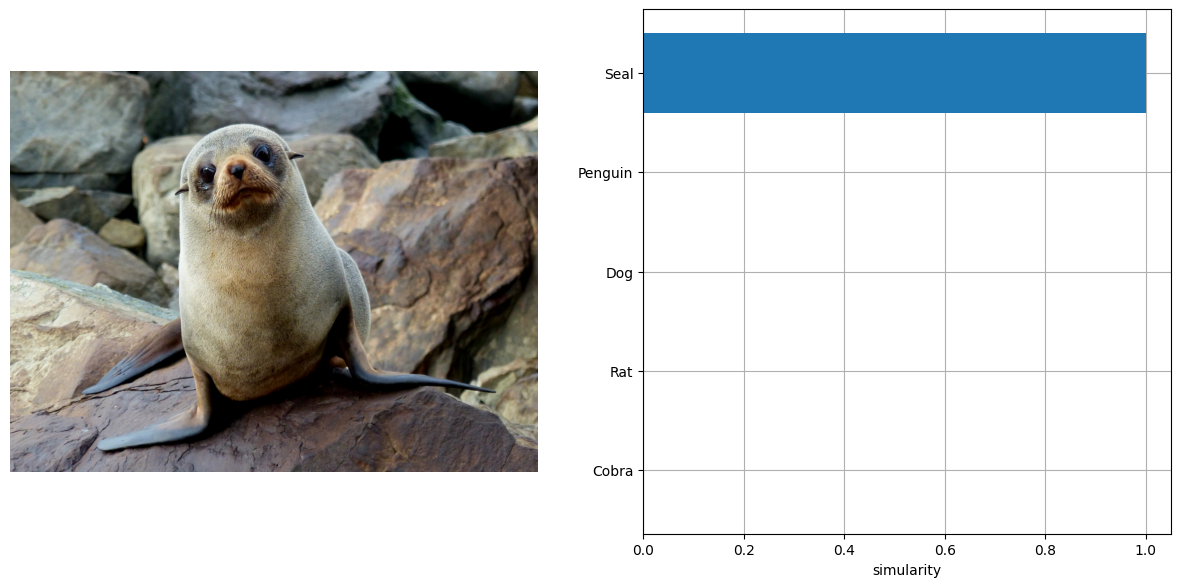

In [22]:
%%skip not $to_quantize.value

compiled_text_model_int8 = core.compile_model(int8_text_model_path, device.value)
compiled_vision_model_int8 = core.compile_model(int8_vision_model_path, device.value)

text_ov_res_int8 = compiled_text_model_int8(text_inputs["input_ids"])
vis_ov_res_int8 = compiled_vision_model_int8(vision_inputs["pixel_values"])

res = calc_simularity_softmax(vis_ov_res_int8[0], text_ov_res_int8[0])
visionize_result(img_furseal, TEXT_INPUTS, np.array(res[0]))

### 比较文件大小
[返回顶部 ⬆️](#Table-of-contents:)

In [23]:
%%skip not $to_quantize.value

from pathlib import Path

fp16_ir_model_size = Path(fp16_text_model_path).with_suffix(".bin").stat().st_size / 1024 / 1024
quantized_model_size = Path(int8_text_model_path).with_suffix(".bin").stat().st_size / 1024 / 1024
print(
    f"Text model:   FP16 model size - {fp16_ir_model_size:.2f} MB; INT8 model size - {quantized_model_size:.2f} MB; Model compression rate: {fp16_ir_model_size / quantized_model_size:.3f}"
)


fp16_ir_model_size = Path(fp16_vision_model_path).with_suffix(".bin").stat().st_size / 1024 / 1024
quantized_model_size = Path(int8_vision_model_path).with_suffix(".bin").stat().st_size / 1024 / 1024
print(
    f"Vision model: FP16 model size - {fp16_ir_model_size:.2f} MB; INT8 model size - {quantized_model_size:.2f} MB;  Model compression rate: {fp16_ir_model_size / quantized_model_size:.3f}"
)

Text model:   FP16 model size - 266.88 MB; INT8 model size - 137.34 MB; Model compression rate: 1.943
Vision model: FP16 model size - 163.83 MB; INT8 model size - 82.83 MB;  Model compression rate: 1.978


### 比较 FP16 IR 模型和量化模型的推理时间
[返回顶部 ⬆️](#Table-of-contents:)

为了衡量 `FP16` 和 `INT8` 模型的推理性能，我们使用校准数据集上的中位数推理时间。  
通过这种方式，我们可以近似估算动态量化模型的加速比。

> **注意**：为了获得最准确的性能估计，建议在关闭其他应用程序并固定输入形状后，在终端或命令提示符中运行 `benchmark_app`。


In [24]:
%%skip not $to_quantize.value

import time


def calculate_inference_time(model_path, calibration_data):
    model = core.compile_model(model_path, device.value)
    inference_time = []
    for batch in calibration_data:
        start = time.perf_counter()
        _ = model(batch)[0]
        end = time.perf_counter()
        delta = end - start
        inference_time.append(delta)
    return np.median(inference_time)

In [25]:
%%skip not $to_quantize.value

fp16_latency = calculate_inference_time(fp16_text_model_path, calibration_data_text)
int8_latency = calculate_inference_time(int8_text_model_path, calibration_data_text)
print(f"Performance speed up for text model: {fp16_latency / int8_latency:.3f}")


fp16_latency = calculate_inference_time(fp16_vision_model_path, calibration_data_vision)
int8_latency = calculate_inference_time(int8_vision_model_path, calibration_data_vision)
print(f"Performance speed up for vision model: {fp16_latency / int8_latency:.3f}")

Performance speed up for text model: 1.424
Performance speed up for vision model: 1.390


## Gradio 演示
[返回顶部 ⬆️](#Table-of-contents:)

您可以提供自己的图片以及用逗号分隔的标签列表来进行零样本分类。

请随意上传图片（使用文件上传窗口），并在文本字段中输入标签名称，使用逗号作为分隔符（例如 `cat,dog,bird`）。


In [26]:
core = ov.Core()

compiled_text_model_int8 = None
compiled_vision_model_int8 = None
if Path(int8_text_model_path).exists() and Path(int8_vision_model_path).exists():
    compiled_text_model_int8 = core.compile_model(int8_text_model_path, device.value)
    compiled_vision_model_int8 = core.compile_model(int8_vision_model_path, device.value)

compiled_text_model_f16 = core.compile_model(fp16_text_model_path, device.value)
compiled_vision_model_f16 = core.compile_model(fp16_vision_model_path, device.value)


def image_text_sim(text, image, quantized_model):
    compiled_text_model = compiled_text_model_int8 if quantized_model else compiled_text_model_f16
    text = text.split(",")
    text_inputs = tokenizer(text, return_tensors="pt", **tokenizer_kwargs)
    emb1_res = compiled_text_model(text_inputs["input_ids"])

    compiled_vision_model = compiled_vision_model_int8 if quantized_model else compiled_vision_model_f16
    vision_input = processor(images=[image])
    emb2_res = compiled_vision_model(vision_input["pixel_values"])

    text_description = "Simularity: "
    simularity = calc_simularity_softmax(emb2_res[0], emb1_res[0], False)
    if len(text) == 1:
        text_description += f"{simularity[0]}"
    else:
        simularity_text = "\n".join([f"{text[i]} {sim:.4f}" for i, sim in enumerate(simularity[0])])
        text_description += f"\n{simularity_text}"
    return text_description


def text_text_sim(text1, text2, quantized_model):
    compiled_text_model = compiled_text_model_int8 if quantized_model else compiled_text_model_f16

    text_inputs = tokenizer(text1, return_tensors="pt", **tokenizer_kwargs)
    emb1_res = compiled_text_model(text_inputs["input_ids"])

    text_inputs = tokenizer(text2, return_tensors="pt", **tokenizer_kwargs)
    emb2_res = compiled_text_model(text_inputs["input_ids"])

    return f"Simularity: {calc_simularity_softmax(emb1_res[0], emb2_res[0], False)[0][0]:.4f}"


def image_image_sim(image1, image2, quantized_model):
    compiled_vision_model = compiled_vision_model_int8 if quantized_model else compiled_vision_model_f16

    vision_input = processor(images=[image1])
    emb1_res = compiled_vision_model(vision_input["pixel_values"])

    vision_input = processor(images=[image2])
    emb2_res = compiled_vision_model(vision_input["pixel_values"])

    return f"Simularity: {calc_simularity_softmax(emb1_res[0], emb2_res[0], False)[0][0]:.4f}"

In [ ]:
if not Path("gradio_helper.py").exists():
    r = requests.get(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/notebooks/jina-clip/gradio_helper.py")
    open("gradio_helper.py", "w").write(r.text)

from gradio_helper import make_demo

model_choice_visible = Path(int8_text_model_path).exists() and Path(int8_vision_model_path).exists()

demo = make_demo(image_text_fn=image_text_sim, text_text_fn=text_text_sim, image_image_fn=image_image_sim, model_choice_visible=model_choice_visible)

try:
    demo.queue().launch(debug=True)
except Exception:
    demo.queue().launch(share=True, debug=True)
# if you are launching remotely, specify server_name and server_port
# demo.launch(server_name='your server name', server_port='server port in int')
# Read more in the docs: https://gradio.app/docs/